<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/10min_1day_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airquino table Data
Average data values (every 10 minutes) of the 30 days before the 30-th of September (included).


We want to find the 30-th of September's anomalies

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-08-01 00:00:00,381.333333,5.000000,409.000000,38.283333,25.300000,9.666667,736.500000,202.500000,260.333333,338.333333
2021-08-01 00:10:00,384.142857,5.000000,407.428571,38.171429,25.257143,10.428571,742.285714,199.428571,258.428571,337.142857
2021-08-01 00:20:00,383.833333,5.000000,407.500000,38.103333,25.200000,10.333333,746.666667,209.166667,259.333333,338.666667
2021-08-01 00:30:00,401.142857,5.142857,411.142857,38.035714,25.042857,11.857143,760.571429,239.000000,261.714286,347.857143
2021-08-01 00:40:00,391.285714,5.142857,407.428571,37.991429,25.085714,13.285714,766.000000,208.571429,259.000000,338.428571
...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:20:00,138.250000,5.000000,408.750000,31.795000,20.450000,7.000000,634.750000,33.250000,211.000000,270.750000
2021-09-30 23:30:00,136.142857,5.000000,408.857143,31.705714,20.357143,7.428571,633.000000,31.571429,211.000000,268.857143
2021-09-30 23:40:00,132.250000,5.000000,407.000000,31.725000,20.525000,6.750000,626.000000,31.750000,210.250000,269.000000


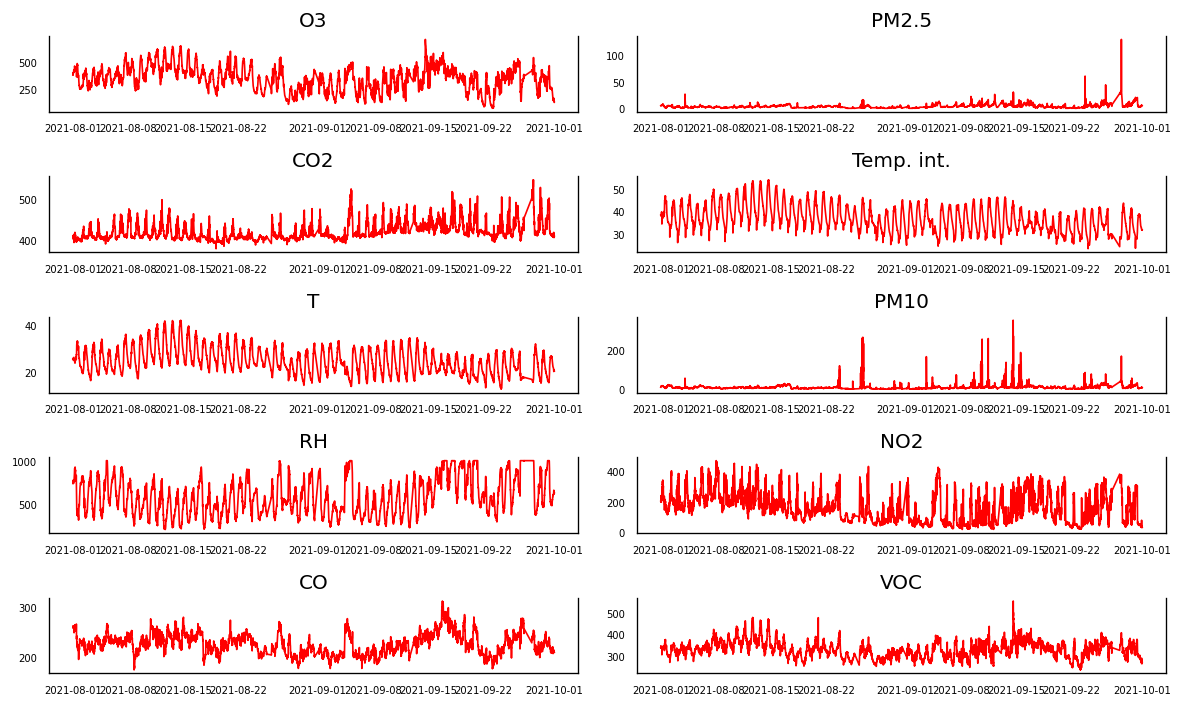

In [1]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('10 minutes', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-08-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-10-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
df=df.dropna()
#fix temp 
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)

display(df)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_in = df[df.columns[i]]
    ax.plot(data_in, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing stationarity 

In [2]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

In [3]:
#to better print the results
df_copy= df.copy()

Converting to stationary with differencing

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

# VAR model

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [4]:
from statsmodels.tsa.api import VAR
max_lag = 25
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19


Calculating the errors

In [5]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


# Testing the mahalanobis errors' distribution and finding the thresholds

In [ ]:
pip install fitter


Make a histogram

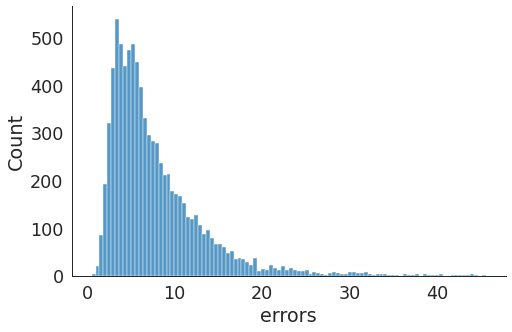

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

0.5290313491322846
45.56812687621996


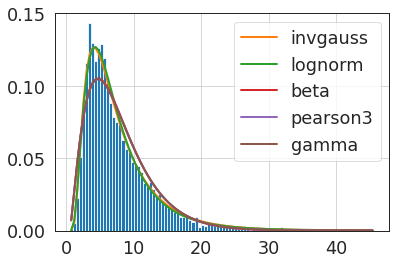

In [8]:
er = new_errors_df["errors"].values
print(min(er))
print(max(er))
f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
f.summary()
inv_gauss_param=f.fitted_param["invgauss"]

threshold low: 20.771072961373388
threshold med: 22.993969957081543
threshold high: 26.81942060085837


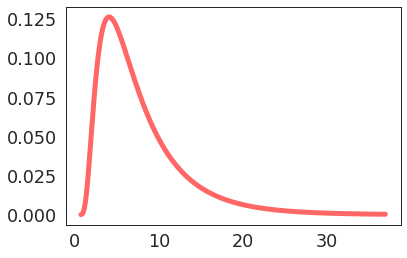

In [9]:
from scipy.stats import invgauss
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

mu = inv_gauss_param[0]
loc, scale = inv_gauss_param[1], inv_gauss_param[2]

#graph to test if the parameters are correct
x = np.linspace(0.765,36.9, 700)
ax.plot(x, invgauss.pdf(x, mu, loc, scale),
       'r-', lw=5, alpha=0.6, label='invgauss pdf')

# using the cdf
found=0
for i in x:
  if ((invgauss.cdf(i,mu, loc, scale)>0.97) & (found<1)):
    threshold_l=i
    found=1
  if ((invgauss.cdf(i,mu, loc, scale)>0.98) & (found<2)):
    threshold_m=i
    found=2
  if ((invgauss.cdf(i,mu, loc, scale)>0.99) & (found<3)):
    threshold_h=i
    found=3
print('threshold low: '+str(threshold_l))
print('threshold med: '+str(threshold_m))
print('threshold high: '+str(threshold_h))

# Finding anomalies with mahalanobis distance

In [10]:
#0 means that is it not an anomaly
def find_anomalies(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i].values >= threshold_low) &(errors.iloc[i].values < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i].values >= threshold_med) &(errors.iloc[i].values < threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i].values >= threshold_high):
      predictions.iloc[i]=3
  return predictions

predictions = find_anomalies(abs(errors_df),threshold_l, threshold_m, threshold_h)

Select how many values do you want to predict: there are 144 values each day.

If you want to find the anomalies of the 30-th of September hom_many should be set at 144

In [11]:
data = df_copy.iloc[selected_lag-1: -1, :]
data['Predictions'] = predictions.values
how_many=144
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 00:00:00,281.000000,12.714286,426.714286,30.605714,18.814286,15.000000,884.142857,92.857143,227.857143,317.857143,0.0
2021-09-30 00:10:00,271.500000,13.000000,428.666667,30.656667,18.700000,14.666667,885.333333,88.666667,227.500000,316.000000,0.0
2021-09-30 00:20:00,266.000000,17.250000,427.500000,30.545000,18.625000,23.250000,890.500000,90.500000,227.250000,316.000000,1.0
2021-09-30 00:30:00,264.833333,14.833333,431.833333,30.438333,18.416667,17.833333,894.833333,95.000000,226.000000,316.000000,0.0
2021-09-30 00:40:00,255.857143,13.428571,427.428571,30.260000,18.457143,15.714286,894.285714,85.857143,224.571429,311.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:10:00,141.571429,5.142857,408.428571,31.904286,20.685714,7.714286,623.428571,34.142857,211.857143,270.714286,0.0
2021-09-30 23:20:00,138.250000,5.000000,408.750000,31.795000,20.450000,7.000000,634.750000,33.250000,211.000000,270.750000,0.0
2021-09-30 23:30:00,136.142857,5.000000,408.857143,31.705714,20.357143,7.428571,633.000000,31.571429,211.000000,268.857143,0.0


In [12]:
data['Predictions'].value_counts()

0.0    128
1.0     10
2.0      4
3.0      2
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance with tables

The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [25]:
index_no = data.columns.get_loc('Predictions')
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values != 0):
    j=i+1
    if(j>=len(data)):
      break
    else:
       while(data.iloc[[j],[index_no]].values != 0):
          j=j+1
          if(j>=len(data)):
            j=j-1
            break
    for s in range(i,j):
      d=0
      for col in df.columns:
        dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=data.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(data)):
      tmp=data.iloc[i -3: j]
      display(tmp)
    else:
      tmp=data.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1     

O3:-5.5
PM2.5:4.25
CO2:-1.1666666666666856
Temp. int.:-0.11166666666666458
T:-0.07499999999999929
PM10:8.583333333333334
RH:5.166666666666629
NO2:1.8333333333333286
CO:-0.25
VOC:0.0
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 00:20:00,266.000000,17.250000,427.500000,30.545000,18.625000,23.250000,890.500000,90.500000,227.250000,316.000000,2.0
2021-09-30 00:30:00,264.833333,14.833333,431.833333,30.438333,18.416667,17.833333,894.833333,95.000000,226.000000,316.000000,0.0
2021-09-30 00:40:00,255.857143,13.428571,427.428571,30.260000,18.457143,15.714286,894.285714,85.857143,224.571429,311.571429,2.0


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,


O3:-8.976190476190453
PM2.5:-1.404761904761905
CO2:-4.40476190476187
Temp. int.:-0.17833333333333456
T:0.04047619047619477
PM10:-2.1190476190476186
RH:-0.5476190476190368
NO2:-9.142857142857139
CO:-1.4285714285714164
VOC:-4.428571428571445
********************
O3:-12.142857142857139
PM2.5:-0.4285714285714288
CO2:0.42857142857138797
Temp. int.:-0.16571428571428726
T:-0.014285714285716011
PM10:-0.2857142857142847
RH:-2.571428571428669
NO2:-6.285714285714292
CO:-0.7142857142857224
VOC:-3.2857142857142776
********************
O3:-6.38095238095238
PM2.5:0.0
CO2:0.9761904761904816
Temp. int.:-0.032619047619050434
T:-0.15952380952380807
PM10:-0.5952380952380949
RH:5.952380952380963
NO2:7.761904761904759
CO:0.6428571428571388
VOC:1.880952380952408
********************
O3:0.6666666666666572
PM2.5:0.4285714285714288
CO2:1.3095238095238528
Temp. int.:-0.0688095238095201
T:-0.22619047619047805
PM10:0.5952380952380949
RH:10.19047619047626
NO2:18.38095238095238
CO:0.7857142857142776
VOC:5.5476190476

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 00:10:00,271.500000,13.000000,428.666667,30.656667,18.700000,14.666667,885.333333,88.666667,227.500000,316.000000,0.0
2021-09-30 00:20:00,266.000000,17.250000,427.500000,30.545000,18.625000,23.250000,890.500000,90.500000,227.250000,316.000000,2.0
2021-09-30 00:30:00,264.833333,14.833333,431.833333,30.438333,18.416667,17.833333,894.833333,95.000000,226.000000,316.000000,0.0
2021-09-30 00:40:00,255.857143,13.428571,427.428571,30.260000,18.457143,15.714286,894.285714,85.857143,224.571429,311.571429,2.0
2021-09-30 00:50:00,243.714286,13.000000,427.857143,30.094286,18.442857,15.428571,891.714286,79.571429,223.857143,308.285714,1.0
2021-09-30 01:00:00,237.333333,13.000000,428.833333,30.061667,18.283333,14.833333,897.666667,87.333333,224.500000,310.166667,1.0
2021-09-30 01:10:00,238.000000,13.428571,430.142857,29.992857,18.057143,15.428571,907.857143,105.714286,225.285714,315.714286,1.0
2021-09-30 01:20:00,245.166667,13.333333,430.000000,29.890000,17.916667,15.500000,913.333333,108.166667,225.833333,317.166667,1.0
2021-09-30 01:30:00,241.400000,12.800000,427.000000,29.832000,18.100000,14.800000,909.000000,90.400000,225.000000,311.400000,1.0


O3:13.333333333333314
PM2.5:2.9999999999999982
CO2:-11.333333333333314
Temp. int.:0.370000000000001
T:0.5166666666666657
PM10:2.5
RH:-5.5
NO2:-20.0
CO:-1.0
VOC:-4.833333333333314
********************
O3:-24.285714285714278
PM2.5:-0.7619047619047592
CO2:14.714285714285722
Temp. int.:0.3776190476190493
T:0.3452380952380949
PM10:6.0476190476190474
RH:-18.35714285714289
NO2:9.023809523809518
CO:1.1666666666666572
VOC:3.5
********************
O3:-2.2142857142857224
PM2.5:2.178571428571427
CO2:1.7857142857142776
Temp. int.:0.2232142857142847
T:-0.0035714285714263383
PM10:-2.4642857142857153
RH:-3.3928571428571104
NO2:12.392857142857167
CO:0.25
VOC:0.5
********************
O3:-11.071428571428555
PM2.5:0.678571428571427
CO2:-11.642857142857167
Temp. int.:0.37535714285714405
T:0.8178571428571395
PM10:-0.25
RH:-26.75
NO2:-31.821428571428555
CO:0.035714285714277594
VOC:-5.928571428571445
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 08:10:00,434.000000,17.400000,499.600000,28.148000,16.260000,23.800000,999.000000,302.200000,240.200000,378.000000,2.0
2021-09-30 08:20:00,436.166667,17.500000,502.000000,28.358333,16.500000,25.000000,999.000000,302.500000,237.833333,370.333333,2.0
2021-09-30 08:30:00,452.666667,15.333333,484.333333,28.666667,16.866667,23.166667,999.000000,303.833333,236.833333,375.333333,0.0
2021-09-30 08:40:00,466.000000,18.333333,473.000000,29.036667,17.383333,25.666667,993.500000,283.833333,235.833333,370.500000,2.0
2021-09-30 08:50:00,441.714286,17.571429,487.714286,29.414286,17.728571,31.714286,975.142857,292.857143,237.000000,374.000000,1.0
2021-09-30 09:00:00,439.500000,19.750000,489.500000,29.637500,17.725000,29.250000,971.750000,305.250000,237.250000,374.500000,2.0
2021-09-30 09:10:00,428.428571,20.428571,477.857143,30.012857,18.542857,29.000000,945.000000,273.428571,237.285714,368.571429,2.0
2021-09-30 09:20:00,406.833333,18.000000,465.833333,30.623333,19.500000,25.833333,898.833333,226.166667,234.166667,353.500000,0.0
2021-09-30 09:30:00,358.857143,16.142857,428.000000,31.758571,21.500000,20.000000,756.857143,76.000000,229.000000,318.857143,0.0


Which anamaly do you want to display? (enter a number)

In [ ]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = data.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values != 0):
    cnt=cnt+1
    j=i+1
    while(data.iloc[[j],[index_no]].values != 0):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(data)):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=data.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(data+1)
    i=j
  else:
    i=i+1    


Type the number of the anomaly you want to display:1
O3:0.7142857142857224
PM2.5:3.0
CO2:-11.857142857142833
Temp. int.:-5.174285714285716
T:-0.3000000000000007
PM10:2.571428571428573
RH:14.14285714285711
NO2:118.71428571428572
CO:-10.857142857142861
VOC:-34.571428571428555
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 03:00:00,298.800000,16.000000,457.800000,29.036000,16.860000,18.800000,967.800000,169.800000,230.600000,333.800000,0
2021-09-30 03:10:00,306.800000,16.400000,457.800000,28.934000,16.760000,19.800000,975.400000,175.600000,231.600000,335.400000,0
2021-09-30 03:20:00,322.285714,17.000000,461.857143,28.834286,16.700000,20.428571,983.857143,190.285714,231.857143,338.571429,0
2021-09-30 03:30:00,323.000000,20.000000,450.000000,23.660000,16.400000,23.000000,998.000000,309.000000,221.000000,304.000000,1
2021-09-30 03:40:00,336.333333,20.666667,471.666667,26.666667,16.333333,25.666667,999.000000,255.000000,221.666667,315.000000,0
2021-09-30 03:50:00,351.000000,20.000000,482.500000,28.252500,16.300000,25.000000,999.000000,250.750000,227.250000,323.500000,0


# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [13]:
anomalies_l= data[(data['Predictions'] == 1)]
anomalies_m= data[(data['Predictions'] == 2)]
anomalies_h= data[(data['Predictions'] == 3)]

Get the day before to compare

In [14]:
day_before= df_copy.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: F

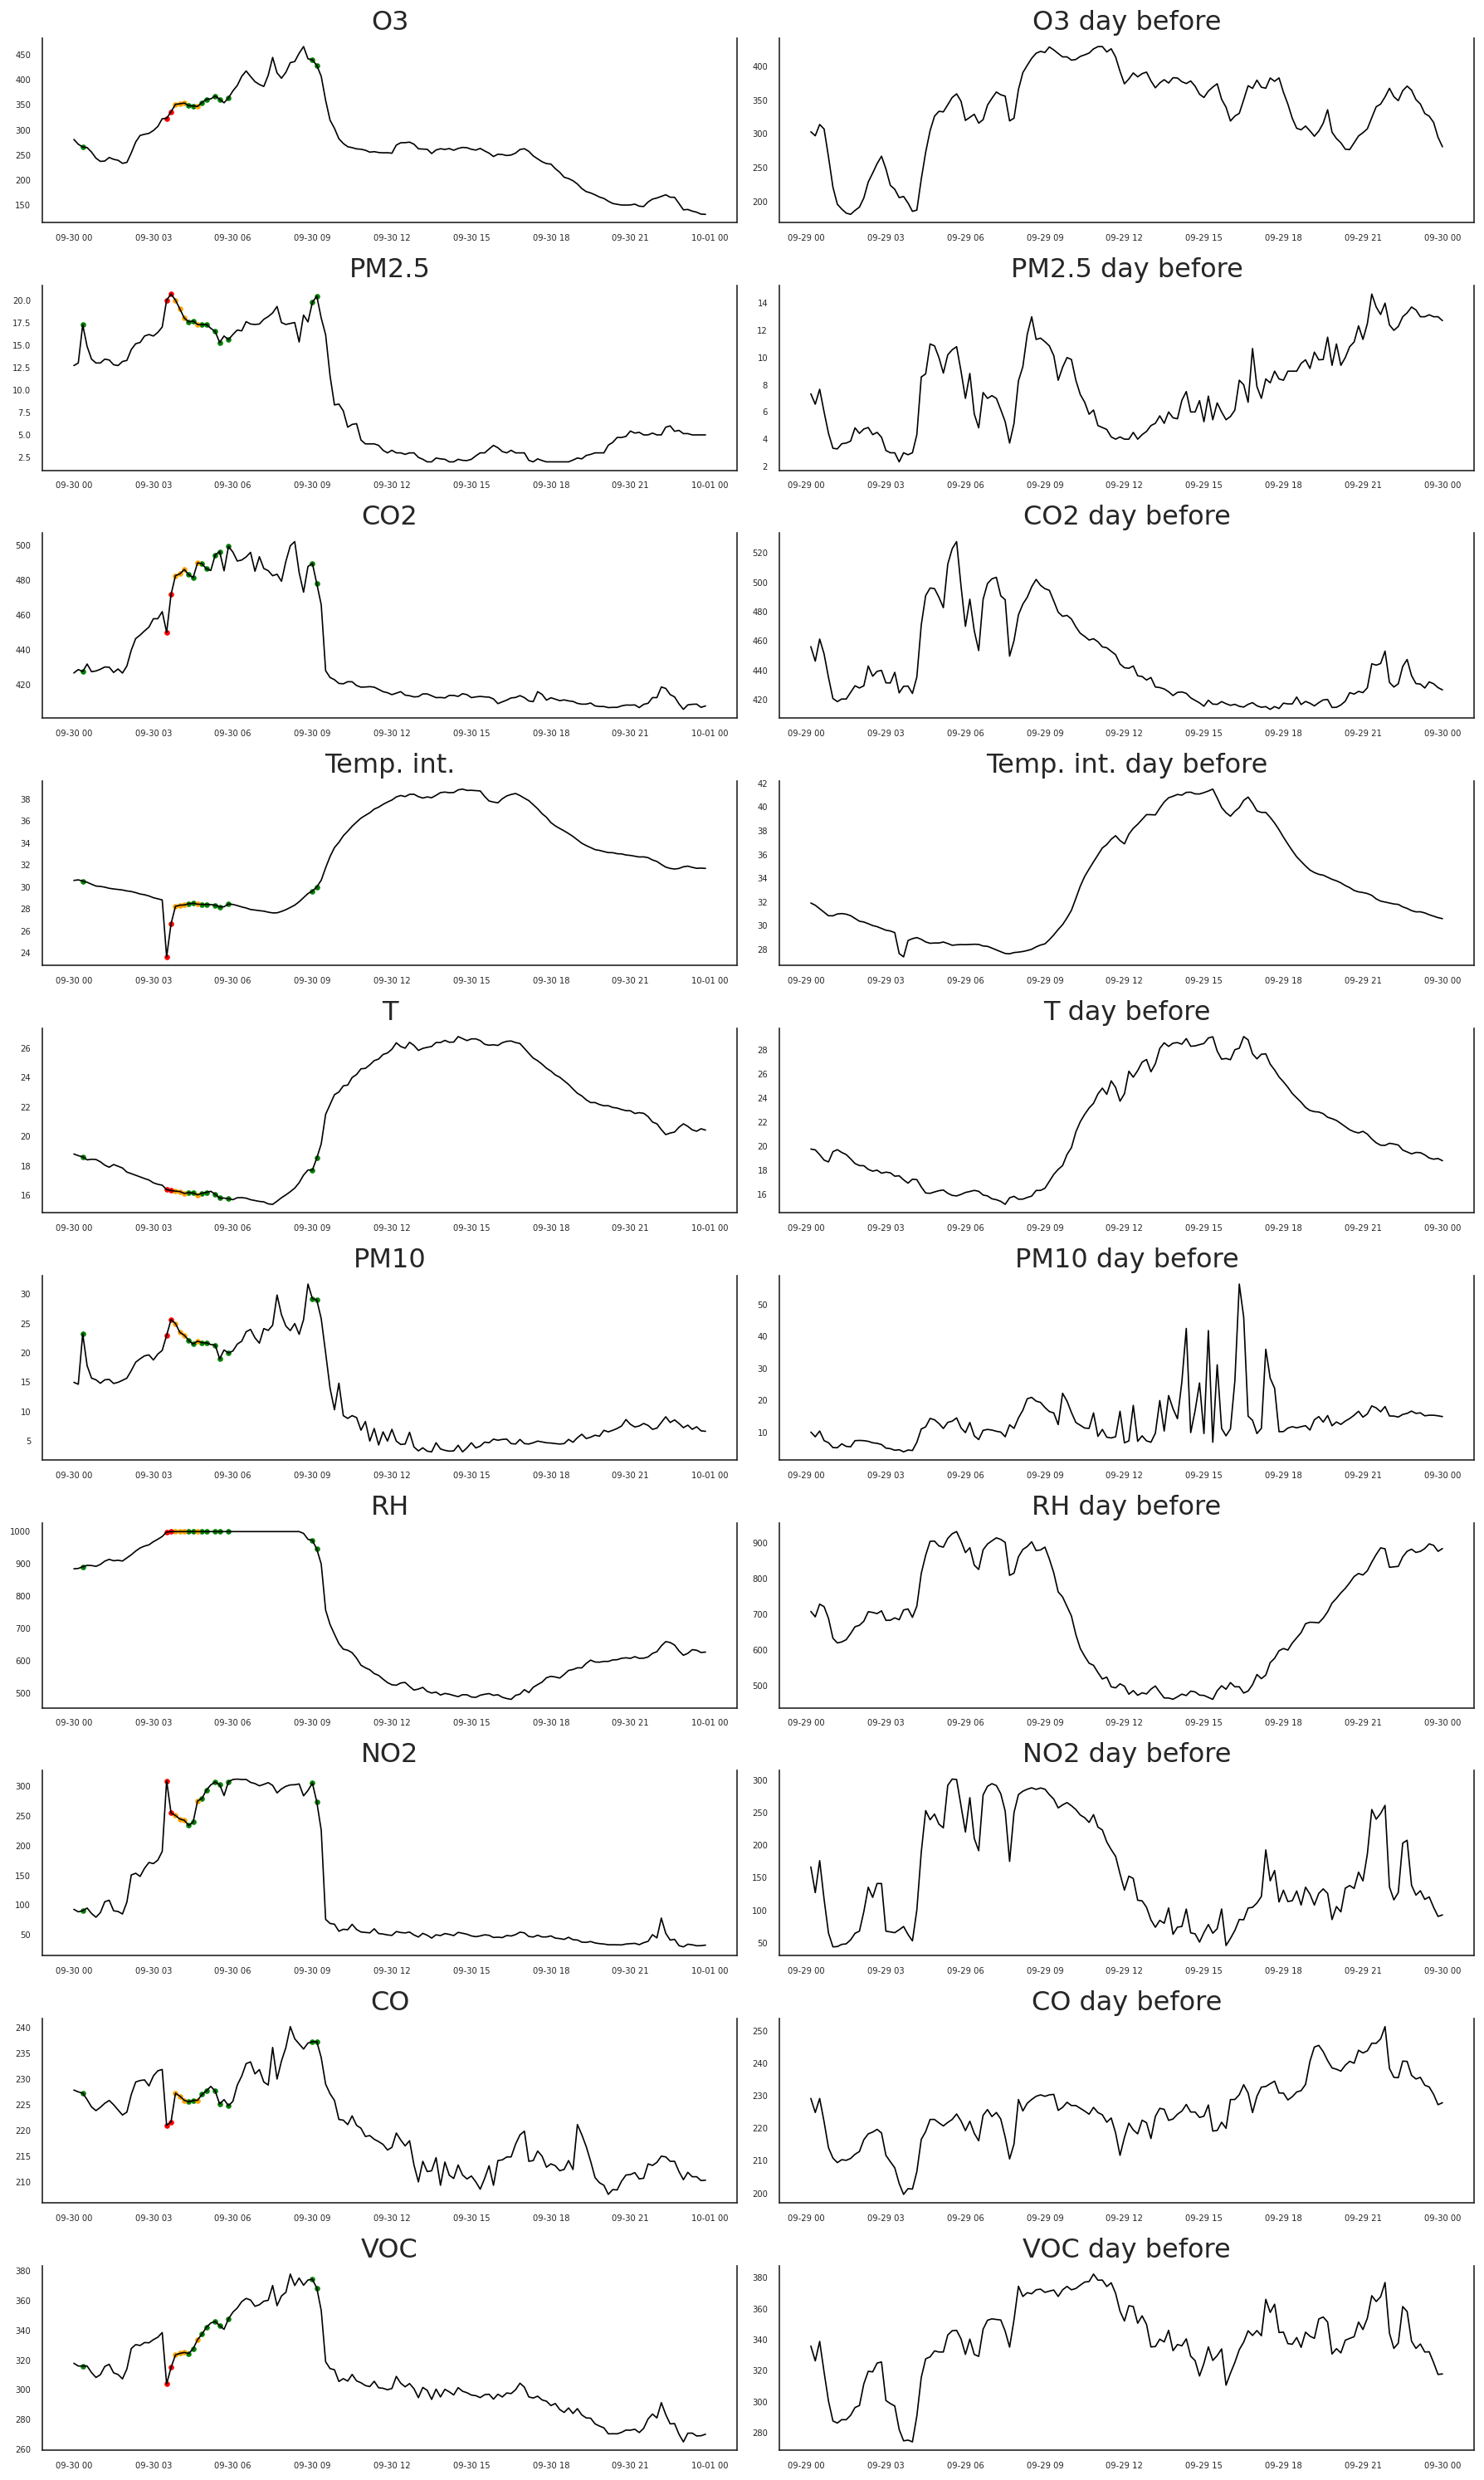

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=10, ncols=2, dpi=120, figsize=(15,25))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = data[df.columns[i/2]]
      ax.plot(data_maha, color='black', linewidth=1)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=10)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=10)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=10)

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();


# Searching the anomalies using distance from the var model expected values

In [16]:
#var expected values into a df
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)



If you need to revert the differencing

In [ ]:
#revert the differencing
df_tra= df_copy[0:-selected_lag]
def invert_transformation(df_train, df, second_diff=False):
    """Revert back the differencing to original scale."""
    df_fc = df.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc
res = invert_transformation(df_tra, var_fit_df, second_diff=False)
how_many=144
res=res.iloc[-how_many:,:]
display(res)     


If you did not use the differencing

In [17]:
how_many=144
res=var_fit_df.iloc[-how_many:,:]


Show how accurate the predictions are

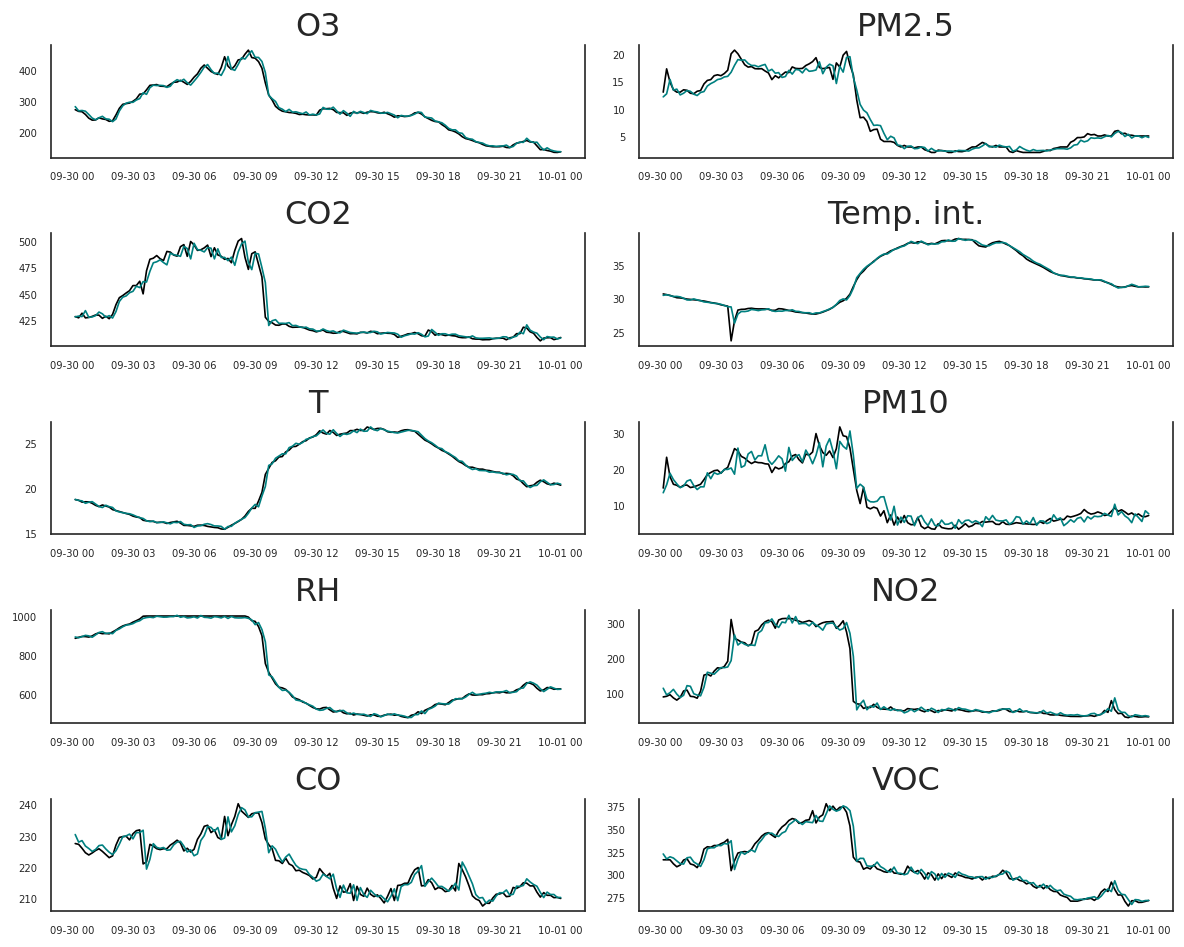

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_compare=df_copy.iloc[-how_many:,:]

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data_2 = df_compare[df.columns[i]]
    data_res=res[res.columns[i]]
    ax.plot(data_2, color='black', linewidth=1)
    ax.plot(data_res, color='teal', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Find distance between predicted values and actual values

In [19]:
import numpy as np
distance = pd.DataFrame(index=df_copy.iloc[-how_many:,:].index)
usable = df_copy.iloc[-how_many:,:]
for col in df.columns:
  distance[col]=abs((usable[col]).values-(res[col]).values)

# Testing the distance's distributions and finding the thresholds

Make histograms

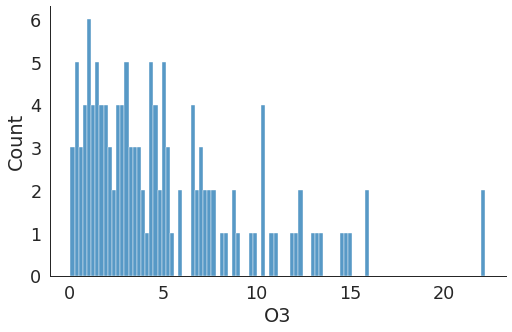

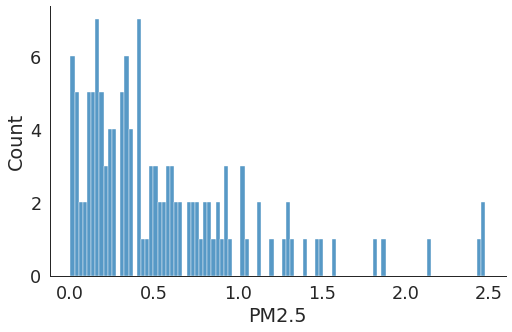

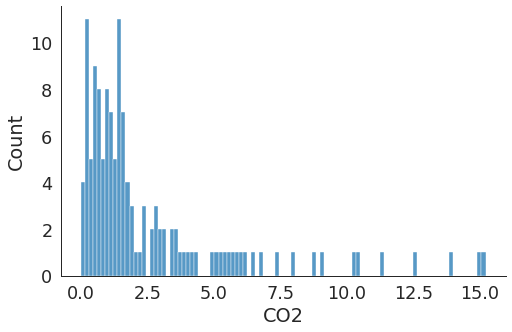

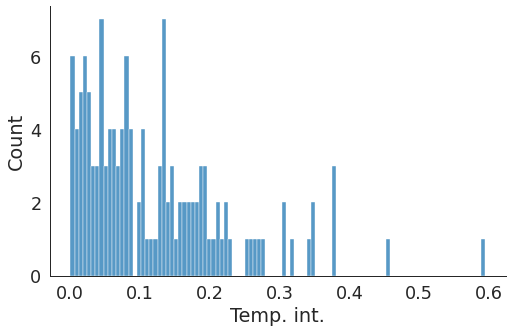

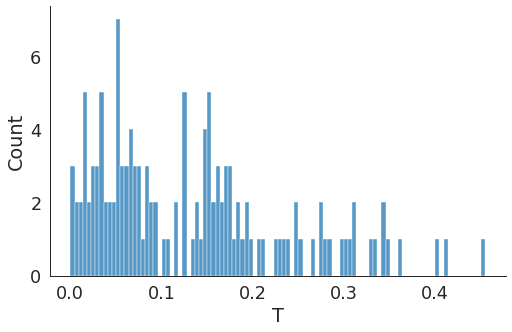

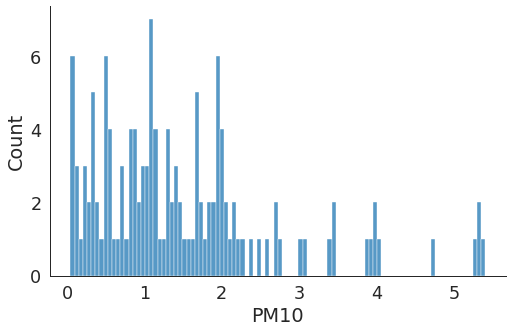

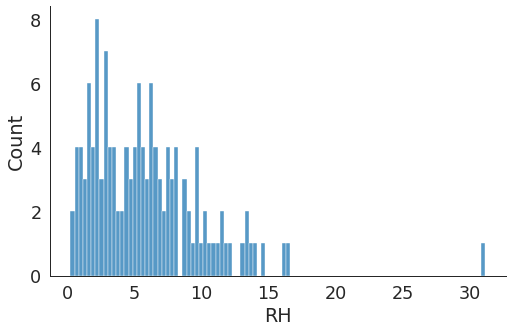

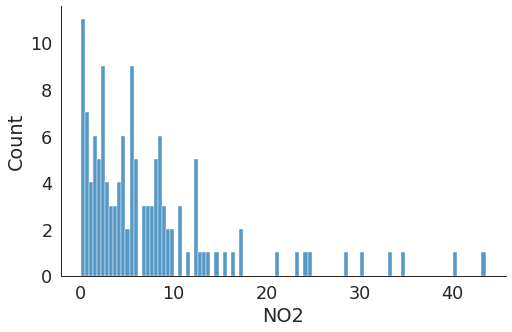

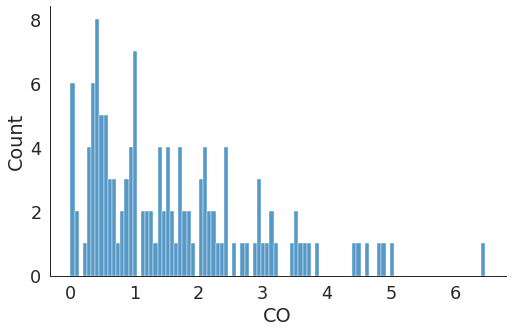

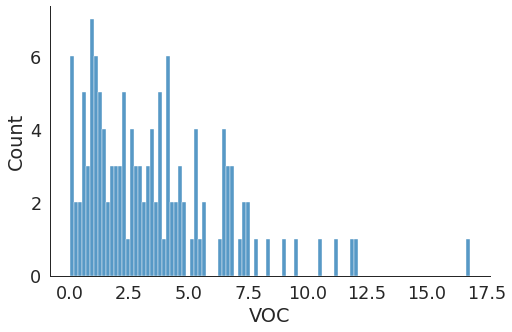

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats


#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic         bic  kl_div
pearson3         0.100410  774.294432 -933.282115     inf
gamma            0.100410  774.298954 -933.282003     inf
beta             0.100910  775.069083 -927.743704     inf
burr             0.110182  782.215010 -916.141219     inf
invgauss         0.110285  779.876569 -920.900517     inf


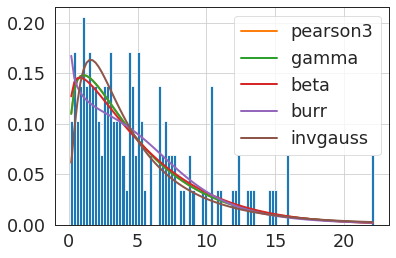

In [21]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
pearson_param_O=f.fitted_param["pearson3"]

threshold_O3 low: 15.235640941399389
threshold_O3 med: 16.47606339574412
threshold_O3 high: 18.22594507240901


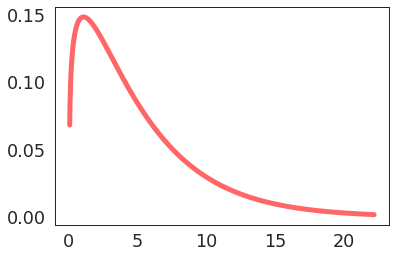

In [22]:
from scipy.stats import pearson3
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

skew = pearson_param_O[0]
loc, scale = pearson_param_O[1], pearson_param_O[2]

#graph to test if the parameters are correct
x = np.linspace(O3_min,O3_max, 1000)
ax.plot(x, pearson3.pdf(x, skew, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((pearson3.cdf(i,skew, loc, scale)>0.96) & (found<1)):
    threshold_O3_l=i
    found=1
  if ((pearson3.cdf(i,skew, loc, scale)>0.97) & (found<2)):
    threshold_O3_m=i
    found=2
  if ((pearson3.cdf(i,skew, loc, scale)>0.98) & (found<3)):
    threshold_O3_h=i
    found=3
print('threshold_O3 low: '+str(threshold_O3_l))
print('threshold_O3 med: '+str(threshold_O3_m))
print('threshold_O3 high: '+str(threshold_O3_h))



             sumsquare_error         aic         bic  kl_div
burr               10.838880  373.082016 -310.424215     inf
weibull_min        10.918614  334.702797 -314.339532     inf
pearson3           10.978668  333.933634 -313.615501     inf
gamma              10.978716  333.932436 -313.614922     inf
beta               11.050275  334.542888 -307.874545     inf


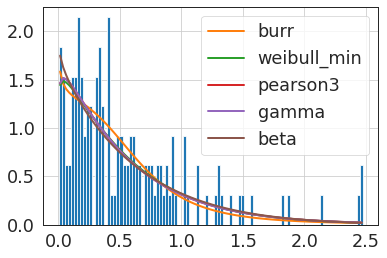

In [23]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_P=f.fitted_param["burr"]

threshold_PM2 low: 1.6333082312717637
threshold_PM2 med: 1.8214895097126897
threshold_PM2 high: 2.1186178440930994


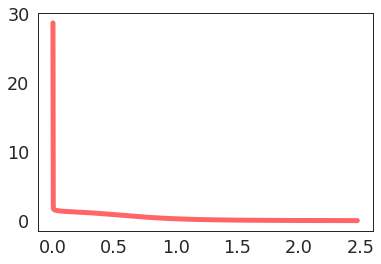

In [24]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_P[0], burr_param_P[1]
loc, scale = burr_param_P[2], burr_param_P[3]

#graph to test if the parameters are correct
x = np.linspace(PM2_min,PM2_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_PM2_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_PM2_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_PM2_h=i
    found=3
print('threshold_PM2 low: '+str(threshold_PM2_l))
print('threshold_PM2 med: '+str(threshold_PM2_m))
print('threshold_PM2 high: '+str(threshold_PM2_h))


          sumsquare_error         aic         bic  kl_div
burr             0.271709  799.824776 -796.997965     inf
lognorm          0.276207  783.782874 -799.713213     inf
invgauss         0.282892  774.628438 -796.556692     inf
expon            0.369595  785.912043 -766.150251     inf
pearson3         0.386194  793.585938 -755.468196     inf


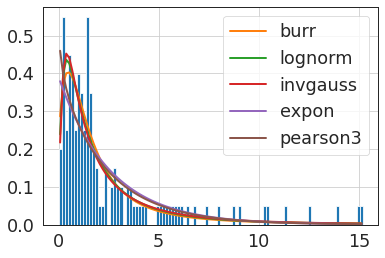

In [25]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_CO2=f.fitted_param["burr"]

threshold_CO2 low: 10.627413389897615
threshold_CO2 med: 12.758563425668347
threshold_CO2 high: 14.296035951474375


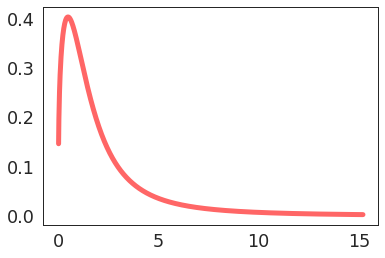

In [26]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_CO2[0], burr_param_CO2[1]
loc, scale = burr_param_CO2[2], burr_param_CO2[3]

#graph to test if the parameters are correct
x = np.linspace(CO2_min,CO2_max , 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_CO2_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_CO2_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.975) & (found<3)):
    threshold_CO2_h=i
    found=3
print('threshold_CO2 low: '+str(threshold_CO2_l))
print('threshold_CO2 med: '+str(threshold_CO2_m))
print('threshold_CO2 high: '+str(threshold_CO2_h))


             sumsquare_error        aic        bic  kl_div
weibull_min       159.471385  83.558643  39.604666     inf
beta              160.267218  79.578482  45.144569     inf
gamma             161.025069  77.793741  40.884480     inf
pearson3          161.026231  77.809376  40.885433     inf
expon             164.613004  71.374950  38.910592     inf


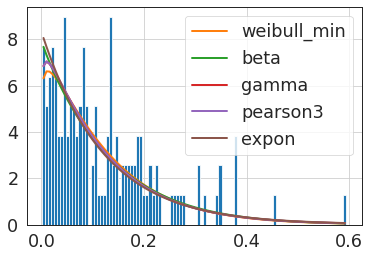

In [27]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
beta_param_Temp= f.fitted_param["beta"]

threshold_Temp low: 0.37561654936712985
threshold_Temp med: 0.40530069361716875
threshold_Temp high: 0.44626481268222246


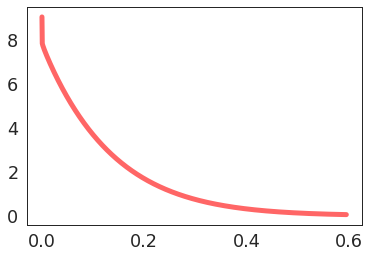

In [28]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = beta_param_Temp[0], beta_param_Temp[1]
loc, scale = beta_param_Temp[2], beta_param_Temp[3]

#graph to test if the parameters are correct
x = np.linspace(Temp_min, Temp_max, 1000)
ax.plot(x, beta.pdf(x, a, b, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((beta.cdf(i,a,b, loc, scale)>0.96) & (found<1)):
    threshold_Temp_l=i
    found=1
  if ((beta.cdf(i,a,b, loc, scale)>0.97) & (found<2)):
    threshold_Temp_m=i
    found=2
  if ((beta.cdf(i,a,b, loc, scale)>0.98) & (found<3)):
    threshold_Temp_h=i
    found=3
print('threshold_Temp low: '+str(threshold_Temp_l))
print('threshold_Temp med: '+str(threshold_Temp_m))
print('threshold_Temp high: '+str(threshold_Temp_h))


             sumsquare_error         aic         bic  kl_div
beta              316.583064  -72.785506  135.002660     inf
weibull_min       319.060241  -59.101857  131.148703     inf
pearson3          320.228889  -57.364026  131.631307     inf
gamma             320.232877  -57.364406  131.632950     inf
triang            337.776643 -102.754719  138.673353     inf


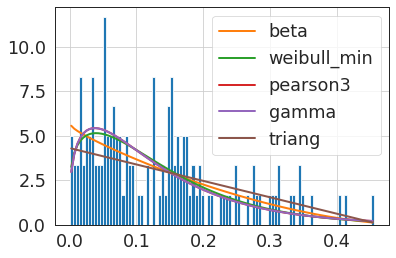

In [29]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
beta_param_T=f.fitted_param["beta"]

hello
threshold_T low: 0.35178276569856726
threshold_T med: 0.3672618828840767
threshold_T high: 0.38638314528970596


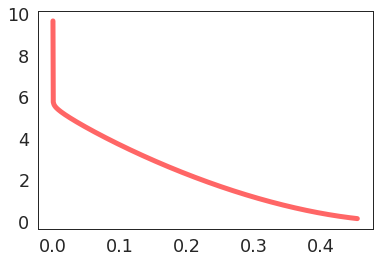

In [30]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = beta_param_T[0], beta_param_T[1]
loc, scale = beta_param_T[2], beta_param_T[3]

#graph to test if the parameters are correct
x = np.linspace(T_min, T_max, 1000)
ax.plot(x, beta.pdf(x, a, b, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((beta.cdf(i,a, b, loc, scale)>0.96) & (found<1)):
    print('hello')
    threshold_T_l=i
    found=1
  if ((beta.cdf(i,a, b, loc, scale)>0.97) & (found<2)):
    threshold_T_m=i
    found=2
  if ((beta.cdf(i,a, b, loc, scale)>0.98) & (found<3)):
    threshold_T_h=i
    found=3
print('threshold_T low: '+str(threshold_T_l))
print('threshold_T med: '+str(threshold_T_m))
print('threshold_T high: '+str(threshold_T_h))


             sumsquare_error         aic         bic  kl_div
burr                2.771494  504.016100 -490.439602     inf
beta                2.961448  437.432439 -481.689103     inf
weibull_min         2.964751  450.621399 -486.424784     inf
gamma               3.026966  451.029042 -483.683420     inf
pearson3            3.026981  451.025617 -483.682789     inf


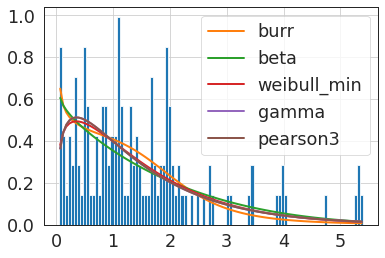

In [31]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_PM10=f.fitted_param["burr"]

threshold_PM10 low: 3.518256315870027
threshold_PM10 med: 3.8076385704714864
threshold_PM10 high: 4.241711952373675


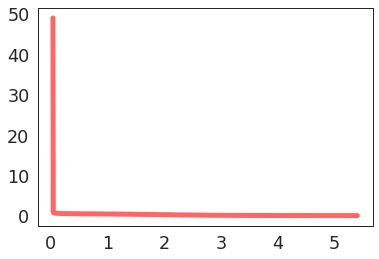

In [32]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_PM10[0], burr_param_PM10[1]
loc, scale = burr_param_PM10[2], burr_param_PM10[3]

#graph to test if the parameters are correct
x = np.linspace(PM10_min, PM10_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_PM10_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_PM10_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_PM10_h=i
    found=3
print('threshold_PM10 low: '+str(threshold_PM10_l))
print('threshold_PM10 med: '+str(threshold_PM10_m))
print('threshold_PM10 high: '+str(threshold_PM10_h))


          sumsquare_error          aic          bic  kl_div
beta             0.047423   992.323052 -1027.419336     inf
gamma            0.047614   987.553601 -1031.771979     inf
pearson3         0.047614   987.558356 -1031.771417     inf
burr             0.050673  1023.669393 -1018.670435     inf
invgauss         0.052346   970.957427 -1019.265202     inf


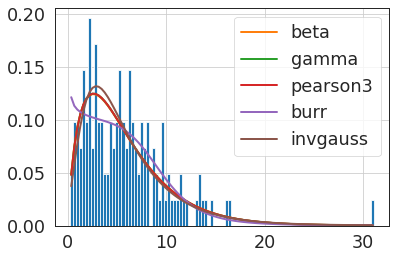

In [33]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
beta_param_RH=f.fitted_param["beta"]

threshold_RH low: 15.129065806760043
threshold_RH med: 16.18140338508129
threshold_RH high: 17.667056436828936


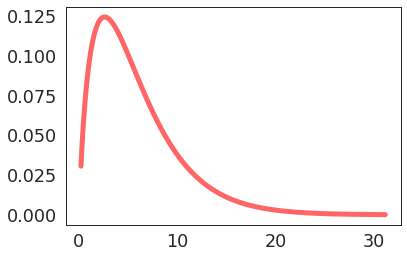

In [34]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = beta_param_RH[0], beta_param_RH[1]
loc, scale = beta_param_RH[2], beta_param_RH[3]

#graph to test if the parameters are correct
x = np.linspace(RH_min, RH_max, 1000)
ax.plot(x, beta.pdf(x, a, b, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((beta.cdf(i,a, b, loc, scale)>0.96) & (found<1)):
    threshold_RH_l=i
    found=1
  if ((beta.cdf(i,a, b, loc, scale)>0.97) & (found<2)):
    threshold_RH_m=i
    found=2
  if ((beta.cdf(i,a, b, loc, scale)>0.98) & (found<3)):
    threshold_RH_h=i
    found=3
print('threshold_RH low: '+str(threshold_RH_l))
print('threshold_RH med: '+str(threshold_RH_m))
print('threshold_RH high: '+str(threshold_RH_h))


             sumsquare_error          aic          bic  kl_div
burr                0.041925   994.563435 -1043.687016     inf
gamma               0.043385   986.598071 -1044.048946     inf
weibull_min         0.043812   982.284178 -1042.757538     inf
pearson3            0.044092  1014.564079 -1041.914921     inf
expon               0.044559   996.583939 -1045.407070     inf


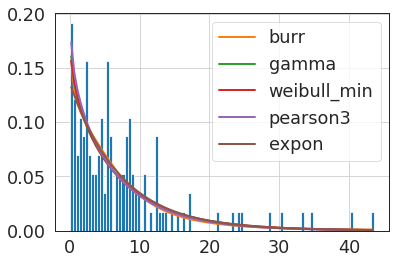

In [35]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_NO2=f.fitted_param["burr"]

threshold_NO2 low: 27.21323281873579
threshold_NO2 med: 31.22334316120404
threshold_NO2 high: 37.80515470155953


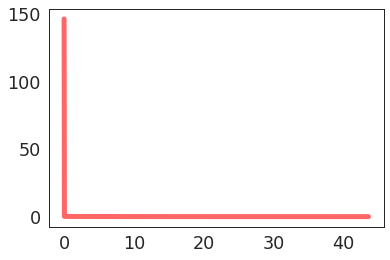

In [36]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_NO2[0], burr_param_NO2[1]
loc, scale = burr_param_NO2[2], burr_param_NO2[3]

#graph to test if the parameters are correct
x = np.linspace(NO2_min, NO2_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_NO2_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_NO2_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_NO2_h=i
    found=3
print('threshold_NO2 low: '+str(threshold_NO2_l))
print('threshold_NO2 med: '+str(threshold_NO2_m))
print('threshold_NO2 high: '+str(threshold_NO2_h))


             sumsquare_error         aic         bic  kl_div
weibull_min         2.008207  516.552315 -537.845458     inf
gamma               2.018313  514.063781 -537.182841     inf
pearson3            2.018317  514.064268 -537.182602     inf
invgauss            2.078123  522.285748 -533.328034     inf
lognorm             2.099914  523.786540 -531.951098     inf


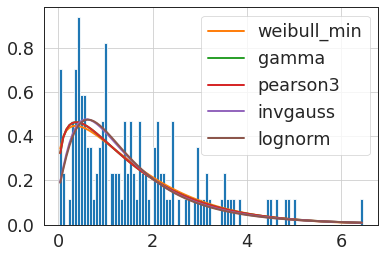

In [37]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
weibull_param_CO=f.fitted_param["weibull_min"]

threshold_CO low: 4.480967636303992
threshold_CO med: 4.810809472015859
threshold_CO high: 5.270001047222576


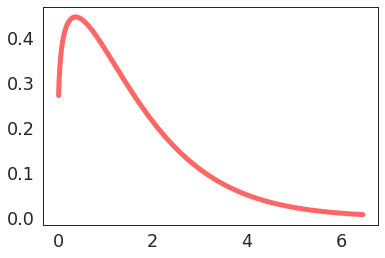

In [38]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c= weibull_param_CO[0]
loc, scale = weibull_param_CO[1], weibull_param_CO[2]

#graph to test if the parameters are correct
x = np.linspace(CO_min, CO_max, 1000)
ax.plot(x, weibull_min.pdf(x, c, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((weibull_min.cdf(i,c, loc, scale)>0.96) & (found<1)):
    threshold_CO_l=i
    found=1
  if ((weibull_min.cdf(i,c, loc, scale)>0.97) & (found<2)):
    threshold_CO_m=i
    found=2
  if ((weibull_min.cdf(i,c, loc, scale)>0.98) & (found<3)):
    threshold_CO_h=i
    found=3
print('threshold_CO low: '+str(threshold_CO_l))
print('threshold_CO med: '+str(threshold_CO_m))
print('threshold_CO high: '+str(threshold_CO_h))


             sumsquare_error         aic         bic  kl_div
burr                0.225756  818.949778 -821.454436     inf
beta                0.227303  764.397275 -820.553132     inf
weibull_min         0.228395  762.298979 -824.802962     inf
gamma               0.232990  753.229355 -822.173773     inf
pearson3            0.232991  753.234224 -822.173197     inf


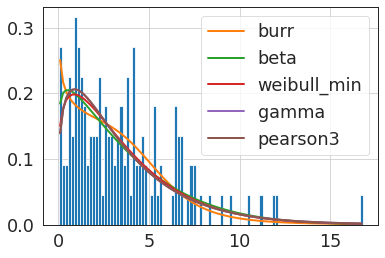

In [39]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_VOC=f.fitted_param["burr"]

threshold_VOC low: 8.708697648332967
threshold_VOC med: 9.381121114263467
threshold_VOC high: 10.389756313159214


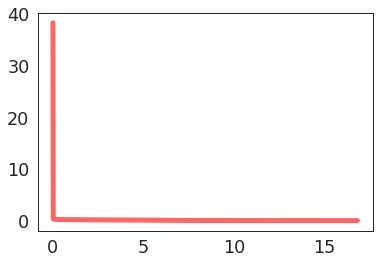

In [40]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_VOC[0], burr_VOC[1]
loc, scale = burr_VOC[2], burr_VOC[3]

#graph to test if the parameters are correct
x = np.linspace(VOC_min, VOC_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_VOC_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_VOC_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_VOC_h=i
    found=3
print('threshold_VOC low: '+str(threshold_VOC_l))
print('threshold_VOC med: '+str(threshold_VOC_m))
print('threshold_VOC high: '+str(threshold_VOC_h))


# Using the thresholds to search anomalies 

In [41]:
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

how_many=144
data_thresh=df_copy.iloc[-how_many:,:]

Finding anomalies with the burr distribution (O3)

In [42]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.values
data_thresh['Predictions_O3'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    136
3.0      6
1.0      2
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [43]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.values
data_thresh['Predictions_PM2.5'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    131
3.0     10
2.0      2
1.0      1
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [44]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    136
3.0      4
1.0      3
2.0      1
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [45]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp_int'] = predictions_Temp.values
data_thresh['Predictions_Temp_int'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    137
1.0      4
3.0      3
Name: Predictions_Temp_int, dtype: int64

Finding anomalies with the burr distribution (T)


In [46]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    137
3.0      6
1.0      1
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [47]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    128
3.0      9
2.0      6
1.0      1
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [48]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    138
3.0      3
2.0      3
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [49]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    136
3.0      4
2.0      2
1.0      2
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [50]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    135
3.0      5
2.0      2
1.0      2
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [51]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.values
data_thresh['Predictions_VOC'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    133
3.0      8
2.0      2
1.0      1
Name: Predictions_VOC, dtype: int64

# Showing the anomalies found with the prediction's distance with graphs

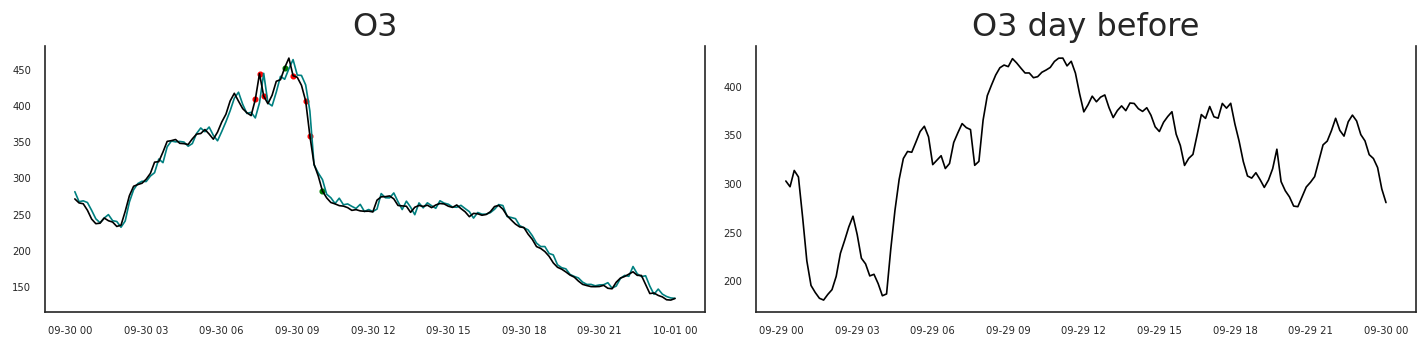

In [52]:
anomalies_O3_l= data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= data_thresh[(data_thresh['Predictions_O3'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['O3']
      ax.plot(data_res, color='teal', linewidth=1)
      data_O3 = data_thresh['O3']
      ax.plot(data_O3, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_O3_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_O3_l['O3'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_O3_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_O3_m['O3'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_O3_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_O3_h['O3'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('O3')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['O3']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('O3 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

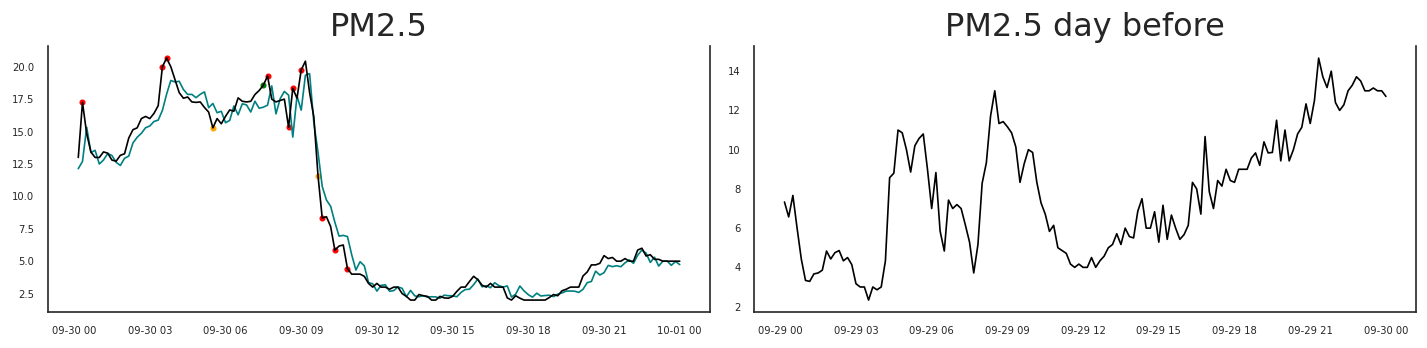

In [53]:
anomalies_PM2_l= data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['PM2.5']
      ax.plot(data_res, color='teal', linewidth=1)
      data_PM2 = data_thresh['PM2.5']
      ax.plot(data_PM2, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_PM2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_PM2_l['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_PM2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_PM2_m['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_PM2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_PM2_h['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('PM2.5')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['PM2.5']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('PM2.5 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

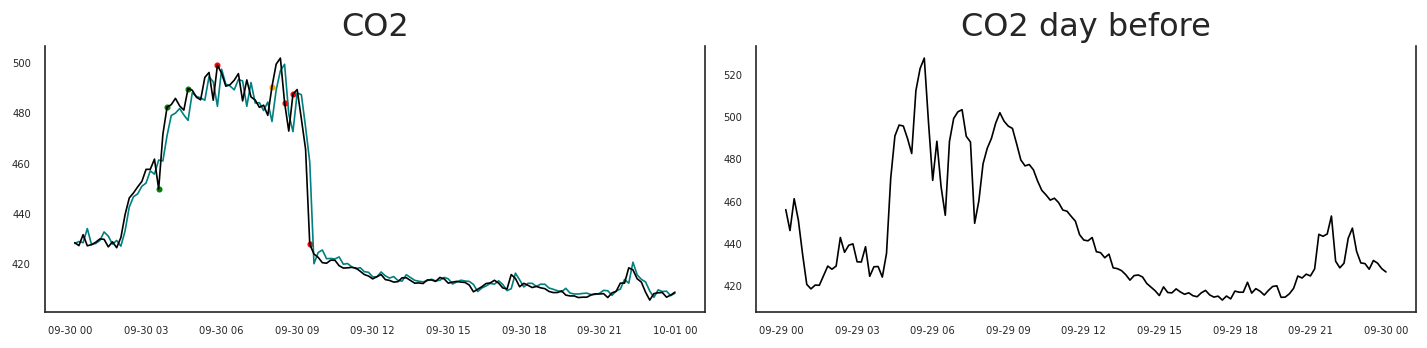

In [54]:
anomalies_CO2_l= data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= data_thresh[(data_thresh['Predictions_CO2'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['CO2']
      ax.plot(data_res, color='teal', linewidth=1)
      data_CO2 = data_thresh['CO2']
      ax.plot(data_CO2, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_CO2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_CO2_l['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_CO2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_CO2_m['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_CO2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_CO2_h['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('CO2')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['CO2']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('CO2 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

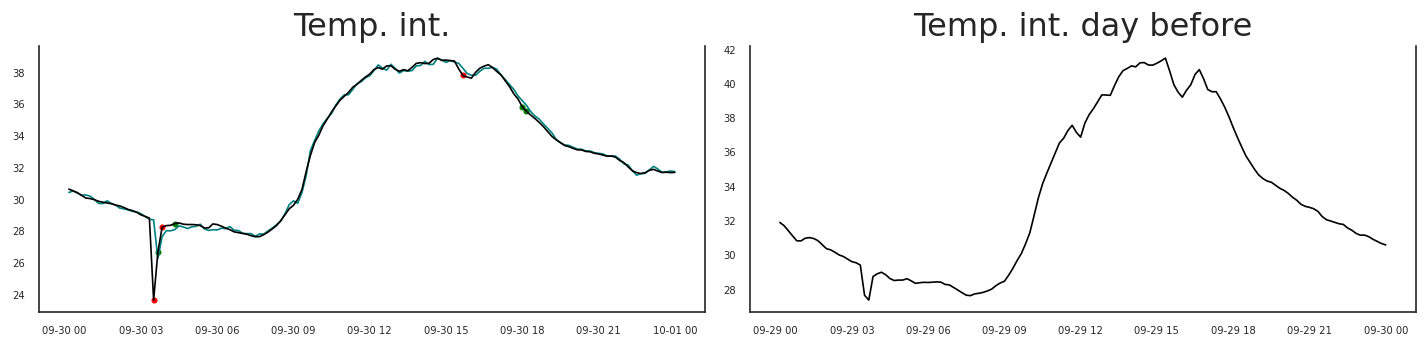

In [55]:
anomalies_Temp_l= data_thresh[(data_thresh['Predictions_Temp_int'] == 1)]
anomalies_Temp_m= data_thresh[(data_thresh['Predictions_Temp_int'] == 2)]
anomalies_Temp_h= data_thresh[(data_thresh['Predictions_Temp_int'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['Temp. int.']
      ax.plot(data_res, color='teal', linewidth=1)
      data_Temp = data_thresh['Temp. int.']
      ax.plot(data_Temp, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_Temp_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_Temp_l['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_Temp_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_Temp_m['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_Temp_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_Temp_h['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('Temp. int.')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['Temp. int.']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('Temp. int. day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

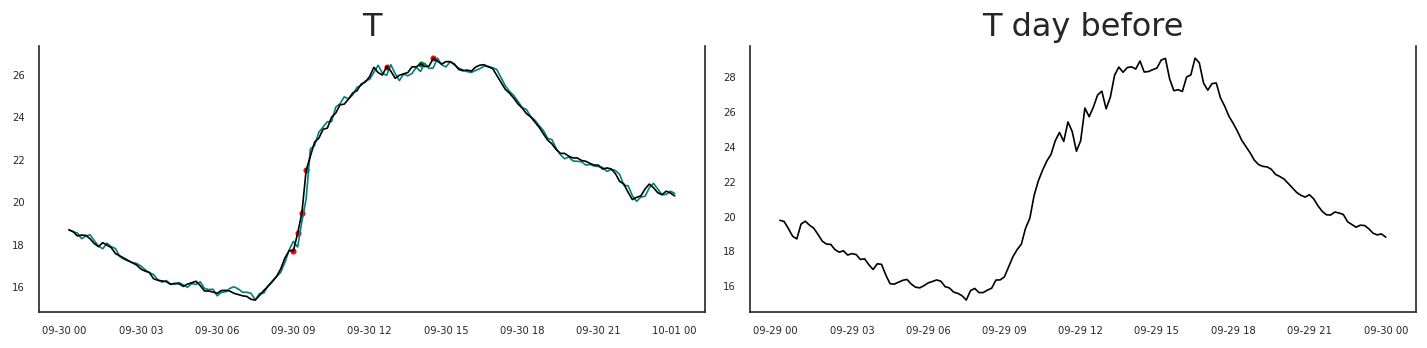

In [56]:
anomalies_T_l= data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= data_thresh[(data_thresh['Predictions_T'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['T']
      ax.plot(data_res, color='teal', linewidth=1)
      data_T = data_thresh['T']
      ax.plot(data_T, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_T_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_T_l['T'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_T_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_T_m['T'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_T_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_T_h['T'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('T')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['T']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('T day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

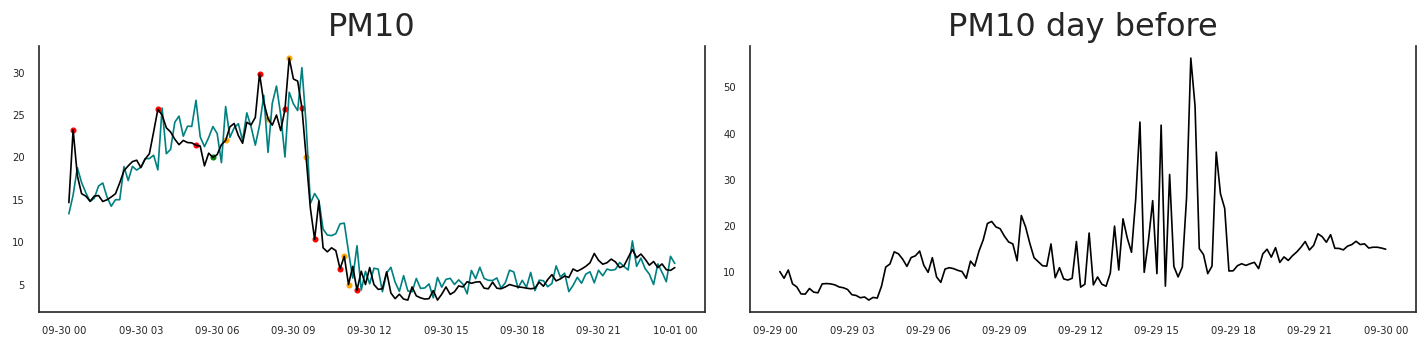

In [57]:
anomalies_PM10_l= data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= data_thresh[(data_thresh['Predictions_PM10'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['PM10']
      ax.plot(data_res, color='teal', linewidth=1)
      data_PM10 = data_thresh['PM10']
      ax.plot(data_PM10, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_PM10_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_PM10_l['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_PM10_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_PM10_m['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_PM10_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_PM10_h['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('PM10')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['PM10']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('PM10 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

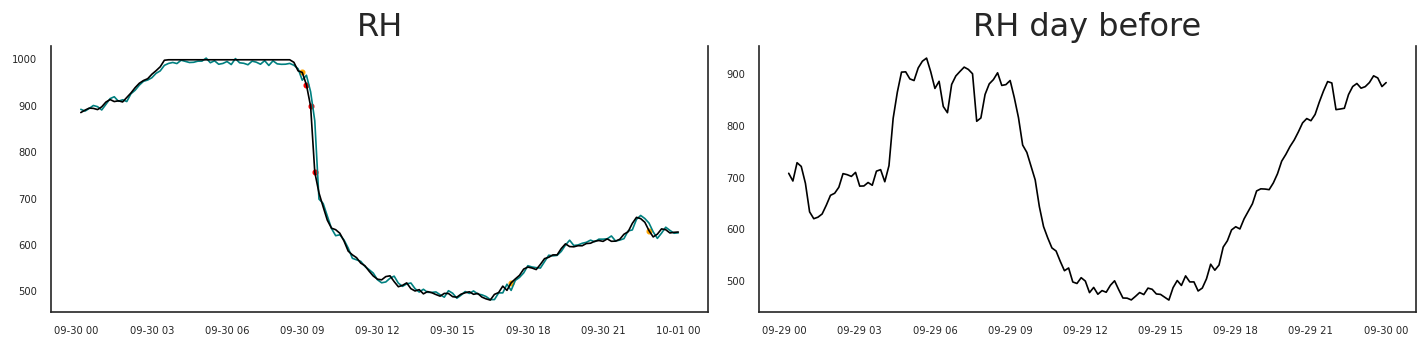

In [58]:
anomalies_RH_l= data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= data_thresh[(data_thresh['Predictions_RH'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['RH']
      ax.plot(data_res, color='teal', linewidth=1)
      data_RH = data_thresh['RH']
      ax.plot(data_RH, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_RH_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_RH_l['RH'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_RH_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_RH_m['RH'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_RH_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_RH_h['RH'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('RH')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['RH']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('RH day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

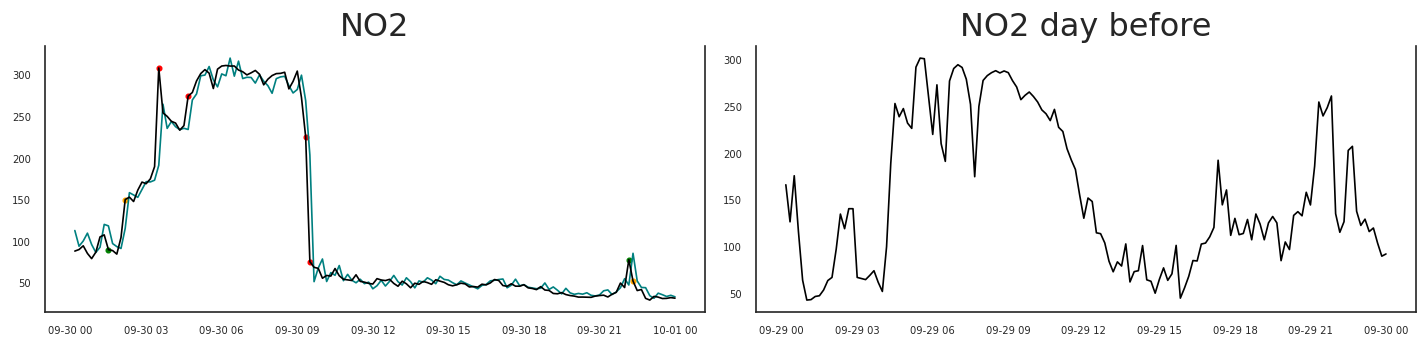

In [59]:
anomalies_NO2_l= data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= data_thresh[(data_thresh['Predictions_NO2'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['NO2']
      ax.plot(data_res, color='teal', linewidth=1)
      data_NO2 = data_thresh['NO2']
      ax.plot(data_NO2, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_NO2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_NO2_l['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_NO2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_NO2_m['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_NO2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_NO2_h['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('NO2')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['NO2']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('NO2 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

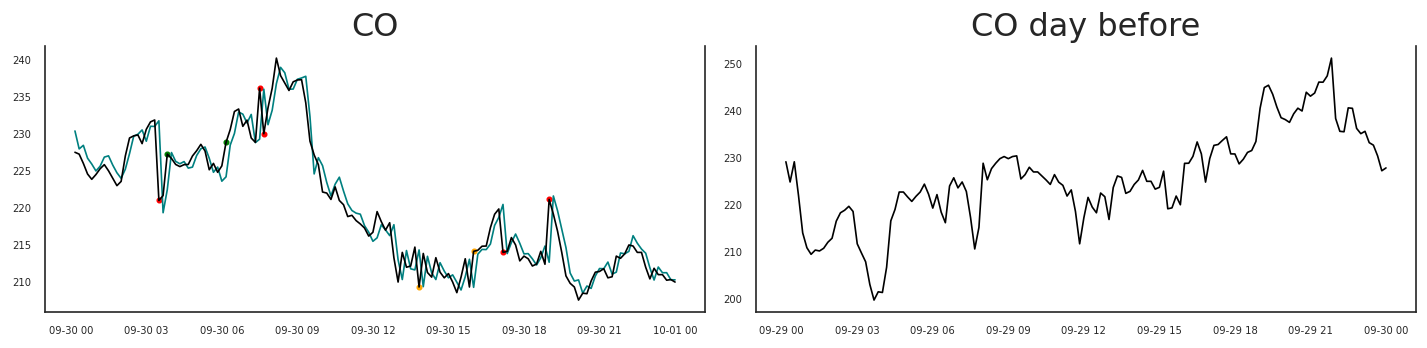

In [60]:
anomalies_CO_l= data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= data_thresh[(data_thresh['Predictions_CO'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['CO']
      ax.plot(data_res, color='teal', linewidth=1)
      data_CO = data_thresh['CO']
      ax.plot(data_CO, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_CO_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_CO_l['CO'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_CO_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_CO_m['CO'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_CO_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_CO_h['CO'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('CO')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['CO']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('CO day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

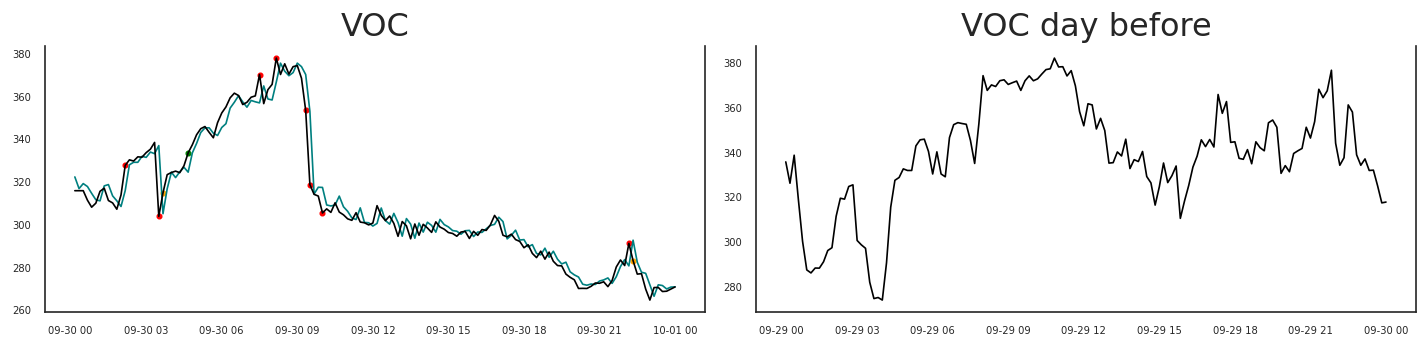

In [61]:
anomalies_VOC_l= data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= data_thresh[(data_thresh['Predictions_VOC'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=res['VOC']
      ax.plot(data_res, color='teal', linewidth=1)
      data_VOC = data_thresh['VOC']
      ax.plot(data_VOC, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_VOC_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_VOC_l['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_VOC_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_VOC_m['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_VOC_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_VOC_h['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('VOC')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['VOC']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('VOC day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

# Showing the anomalies using distance from the var model expected values



The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [ ]:
index_no = results_pred.columns.get_loc('Predictions')
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    j=i+1
    if(j>=len(results_pred)):
      break
    else:
       while(results_pred.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(results_pred)):
            j=j-1
            break
    for s in range(i,j):
      print(s)
      d=0
      for col in df.columns:
        dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=results_pred.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(results_pred)):
      tmp=results_pred.iloc[i -3: j]
      display(tmp)
    else:
      tmp=results_pred.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1  

Which anamaly do you want to display? (enter a number)

In [ ]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = results_pred.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    while(results_pred.iloc[[j],[index_no]].values == 1):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(results_pred)):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=results_pred.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(results_pred+1)
    i=j
  else:
    i=i+1  

# Forecasting using the VAR model

Splitting the series into train and testing data (nobs= how many values are test values)

In [63]:
nobs = 144
df_train, df_test = df_copy[0:-nobs], df_copy[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(8285, 10)
(144, 10)


In [64]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
adf_test_results  

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

if no differencing

In [65]:
df_after=df_train

In [66]:
from statsmodels.tsa.api import VAR

model = VAR(df_after)
model_fitted = model.fit(selected_lag)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [69]:
# Input data for forecasting
forecast_input = df_after.values
forecast_input

array([[381.33333333,   5.        , 409.        , ..., 202.5       ,
        260.33333333, 338.33333333],
       [384.14285714,   5.        , 407.42857143, ..., 199.42857143,
        258.42857143, 337.14285714],
       [383.83333333,   5.        , 407.5       , ..., 209.16666667,
        259.33333333, 338.66666667],
       ...,
       [317.        ,  13.        , 430.85714286, ..., 104.42857143,
        230.42857143, 325.14285714],
       [295.        ,  13.        , 428.25      , ...,  90.5       ,
        227.25      , 317.5       ],
       [281.        ,  12.71428571, 426.71428571, ...,  92.85714286,
        227.85714286, 317.85714286]])

Forecast number is the number of observetion you want to forecast. You should choose 6 if you want to forecast the next hour

In [70]:
# Forecast
forecast_number=6
fc = model_fitted.forecast(y=forecast_input, steps=forecast_number)
df_forecast = pd.DataFrame(fc, index=df_copy.index[-nobs:-(nobs-forecast_number)], columns=df_copy.columns + '_2d')
df_forecast

,O3_2d,PM2.5_2d,CO2_2d,Temp. int._2d,T_2d,PM10_2d,RH_2d,NO2_2d,CO_2d,VOC_2d
Dates,,,,,,,,,,
2021-09-30 00:10:00,281.872030,12.056293,428.374961,30.443359,18.709101,13.320010,892.665966,114.451135,230.469049,322.742335
2021-09-30 00:20:00,284.108015,11.846404,430.234906,30.474350,18.601131,14.885250,896.820153,119.078857,230.750326,323.216729
2021-09-30 00:30:00,287.013890,11.630260,431.059799,30.388893,18.523400,13.876395,898.229743,124.336892,231.268159,325.068934
2021-09-30 00:40:00,292.455574,12.070563,434.149285,30.344948,18.433250,16.330684,900.268126,137.415809,231.321508,326.548858
2021-09-30 00:50:00,298.369698,12.302109,435.974155,30.327793,18.311786,15.611559,904.025319,145.892123,232.375937,329.225233
2021-09-30 01:00:00,303.650736,11.797030,436.278223,30.300308,18.295181,15.154330,903.169181,149.443963,232.924305,330.323281


If no differencing

In [71]:
df_results=df_forecast

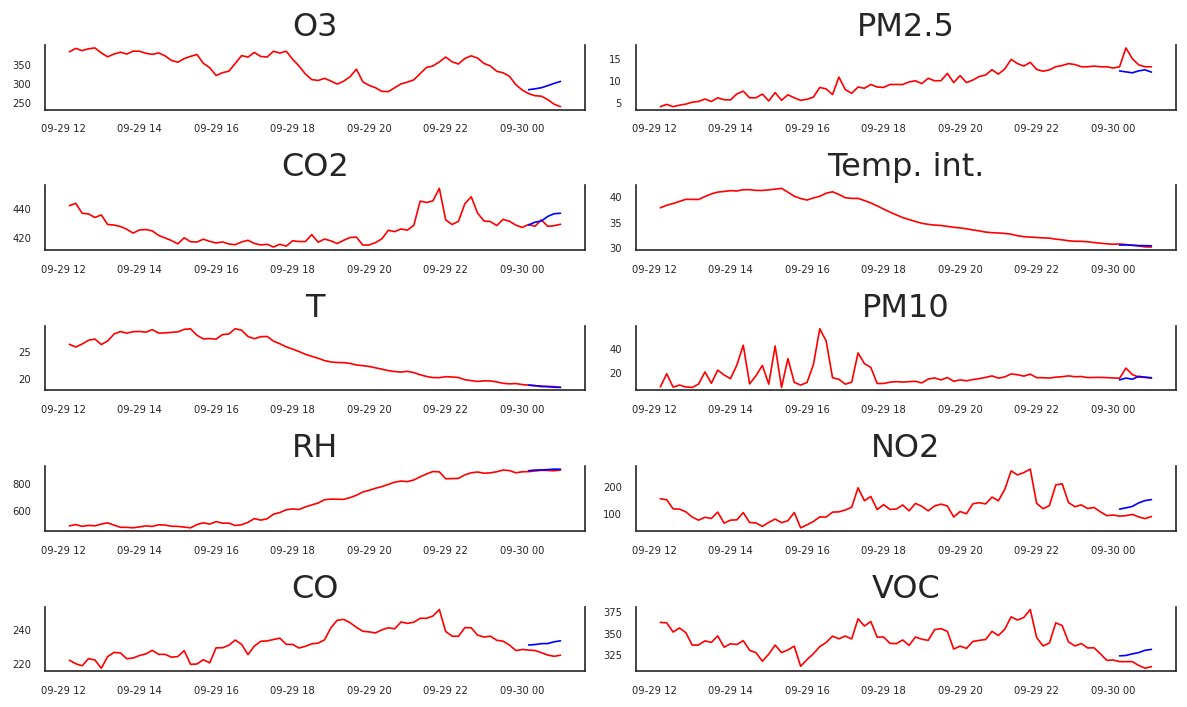

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_3 = df_copy[df_copy.columns[i]].iloc[-(144+72):-(144-forecast_number)]
    data_fc=df_results[df_results.columns[i]]
    ax.plot(data_3, color='red', linewidth=1)
    ax.plot(data_fc, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Forecast number is the number of observetion you want to forecast. You should choose 6 if you want to forecast the next hour

In [73]:
# Forecast
forecast_number=12
fc = model_fitted.forecast(y=forecast_input, steps=forecast_number)
df_forecast = pd.DataFrame(fc, index=df_copy.index[-nobs:-(nobs-forecast_number)], columns=df_copy.columns + '_2d')
df_forecast

,O3_2d,PM2.5_2d,CO2_2d,Temp. int._2d,T_2d,PM10_2d,RH_2d,NO2_2d,CO_2d,VOC_2d
Dates,,,,,,,,,,
2021-09-30 00:10:00,281.872030,12.056293,428.374961,30.443359,18.709101,13.320010,892.665966,114.451135,230.469049,322.742335
2021-09-30 00:20:00,284.108015,11.846404,430.234906,30.474350,18.601131,14.885250,896.820153,119.078857,230.750326,323.216729
2021-09-30 00:30:00,287.013890,11.630260,431.059799,30.388893,18.523400,13.876395,898.229743,124.336892,231.268159,325.068934
2021-09-30 00:40:00,292.455574,12.070563,434.149285,30.344948,18.433250,16.330684,900.268126,137.415809,231.321508,326.548858
2021-09-30 00:50:00,298.369698,12.302109,435.974155,30.327793,18.311786,15.611559,904.025319,145.892123,232.375937,329.225233
2021-09-30 01:00:00,303.650736,11.797030,436.278223,30.300308,18.295181,15.154330,903.169181,149.443963,232.924305,330.323281
2021-09-30 01:10:00,304.598339,11.466011,436.272844,30.254153,18.258131,15.242225,902.993721,149.019555,232.808155,329.212749
2021-09-30 01:20:00,306.790441,11.516946,437.157241,30.133234,18.226698,15.356195,902.997755,155.041739,233.027071,329.515087
2021-09-30 01:30:00,310.286430,11.789237,438.854197,30.128086,18.147553,17.182242,905.527727,163.480446,233.498721,331.205308


If no differencing

In [74]:
df_results=df_forecast

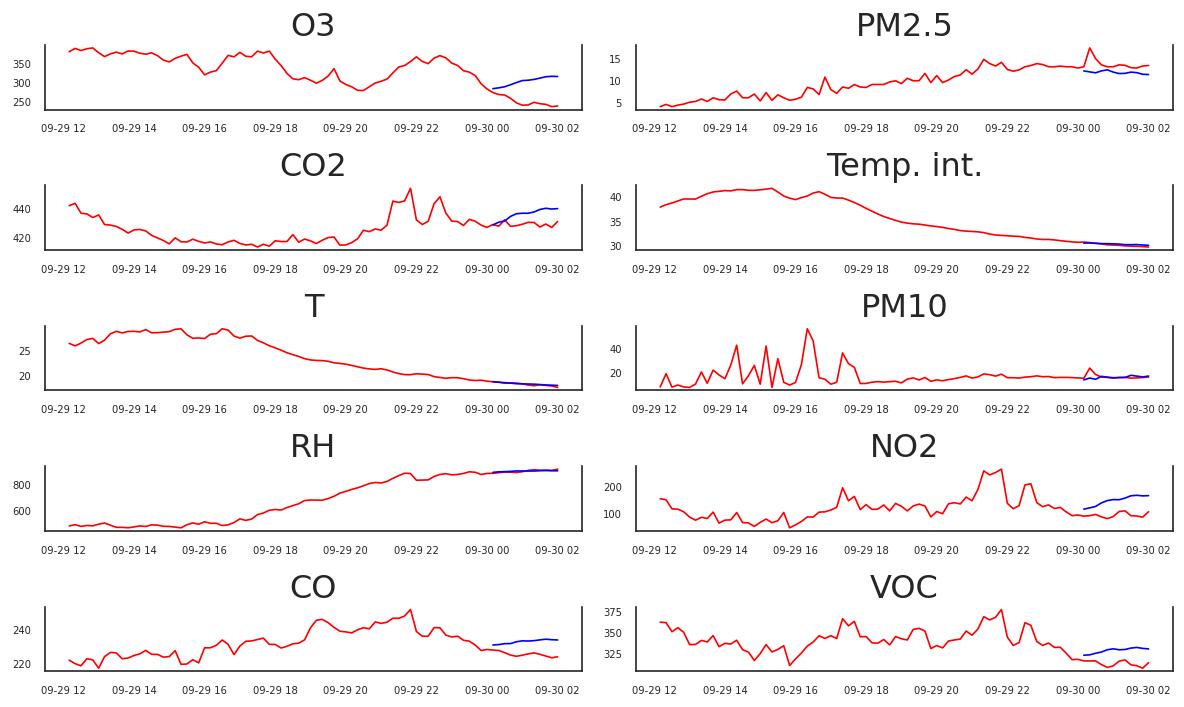

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_3 = df_copy[df_copy.columns[i]].iloc[-(144+72):-(144-forecast_number)]
    data_fc=df_results[df_results.columns[i]]
    ax.plot(data_3, color='red', linewidth=1)
    ax.plot(data_fc, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();